In [155]:
import numpy as np
from numpy import pi
from numpy.linalg import norm
from matplotlib import pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter

import simulation
import algorithm

## 仿真实验


### 声场仿真

设置参数


In [156]:
f = 37500  # 声源频率
T = 1  # 采样时长
r = 300  # 距离
theta = np.deg2rad(60)  # 角度

d = 0.12
K = 0.128/d
c = 1500  # 声速
fs = 1e6  # 采样频率1M

#### 几何模型

In [157]:
d1, d2, d3 = (K + 1) * d / 2, (K - 1) * d / 2, (K + 1) * d / 2
S = np.array([r * np.cos(theta), r * np.sin(theta)])  # FIXME: 这x该是-, 方位近似解需要重新推导一下

r1 = float(norm(S - [-d1, 0]))
r2 = float(norm(S - [-d2, 0]))
r3 = float(norm(S - [d3, 0]))

# 真实时延
t12 = (r1 - r2) / c
t23 = (r2 - r3) / c

#### 生成各阵元电信号AD采样后信号

In [158]:
# 三阵元处采样信号序列 # TODO: 改成用同一个函数生成, 包含阵元的坐标, 生成信号矩阵
x1 = simulation.sig_gen(c, f, r1, fs, T)
x2 = simulation.sig_gen(c, f, r2, fs, T)
x3 = simulation.sig_gen(c, f, r3, fs, T)

##### 信号图像

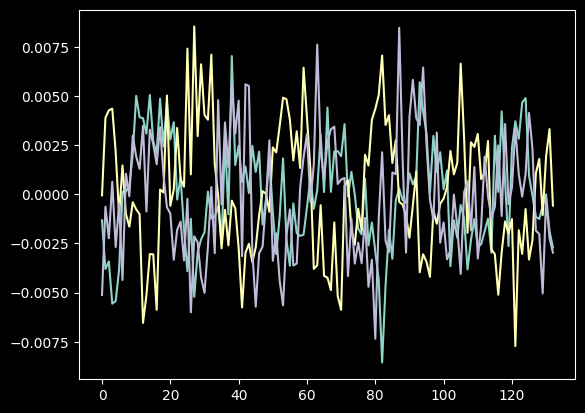

In [159]:
# 绘制x1, x2前5个周期
plt.plot(x1[:int(5*fs/f)])
plt.plot(x2[:int(5*fs/f)])
plt.plot(x3[:int(5*fs/f)])
plt.show()

### 定位

#### 时延估计

In [160]:
method = 'cpsd'
# method = 'xcorr'

tau12_hat = algorithm.time_delay_estimation(x1, x2, f, fs, method=method)
tau23_hat = algorithm.time_delay_estimation(x2, x3, f, fs, method=method)

In [161]:
phi12_frac, phi23_frac = tau12_hat * f, tau23_hat * f
# 限制在[-0.5, 0.5)范围内
phi12_frac, phi23_frac = np.mod(phi12_frac + 0.5, 1) - 0.5, np.mod(phi23_frac + 0.5, 1) - 0.5

In [162]:
print(f'真实相位差phi12: {(phi12:=t12*f)}\n相关相位差phi12\': {phi12_frac}\n差异: {np.abs(phi12 - phi12_frac) / phi12 * 100:.2f}%')
print(f'真实相位差phi23: {(phi23:=t23*f)}\n相关相位差phi23\': {phi23_frac}\n差异: {np.abs(phi23 - phi23_frac) / phi23 * 100:.2f}%')

真实相位差phi12: 1.5004799007058978
相关相位差phi12': -0.48439522259807816
差异: 132.28%
真实相位差phi23: 1.5995199006880512
相关相位差phi23': -0.4124524890313772
差异: 125.79%


#### 解相位模糊

In [163]:
# FIXME: 这里精度不够
phi12_ar, phi23_ar = algorithm.ambiguity_resolution(np.array([phi12_frac]), np.array([phi23_frac]), K, d)
phi12_ar, phi23_ar = phi12_ar[0], phi23_ar[0]

In [164]:
print(f'真实相位差phi12: \t{phi12}\n解模糊后相位差phi12_ar: \t{phi12_ar}\n差异: {np.abs(phi12 - phi12_ar) / phi12 * 100:.2f}%')
print(f'真实相位差phi23: \t{phi23}\n解模糊后相位差phi23_ar: \t{phi23_ar}\n差异: {np.abs(phi23 - phi23_ar) / phi23 * 100:.2f}%')

真实相位差phi12: 	1.5004799007058978
解模糊后相位差phi12_ar: 	1.515604777401922
差异: 1.01%
真实相位差phi23: 	1.5995199006880512
解模糊后相位差phi23_ar: 	1.5875475109686228
差异: 0.75%


#### 解算方位

In [165]:
r_e, theta_e = algorithm.far_locate(phi12_ar / f, phi23_ar/f, c, K, d)

# TODO: 解决距离估计因为精度趋近0或inf问题
print(f'真实方位角: \t{theta/pi*180}度\n估计方位角: \t{theta_e/pi*180}度\n绝对误差: \t{theta/pi*180 - theta_e/pi*180}度\n相对误差: \t{(theta - theta_e)/theta * 100}%')
# print(algorithm.far_locate(t12, t23, c, K, d))

真实方位角: 	60.0度
估计方位角: 	59.9663565985385度
绝对误差: 	0.03364340146149658度
相对误差: 	0.05607233576915911%
